# **author: Danny Petschke**
# **date:   2021-03-01**

* import required modules ...

In [2]:
from __future__ import print_function
import random
from random import randrange, uniform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
import scipy as scipy
from scipy import constants
from scipy import special
from scipy.special import gammainc
import scipy.stats as stats

import numpy as np
import os, time, sys

* definition of all required functions used in the Monte-Carlo simulation code ...

In [3]:
# draw a sphere with the start/end points of the diffusion showing the particle track ...
def showSphereWithDiffusionPath(radius=1000., 
                                track=[]):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  # draw bounding cube ...
  r = [-radius, radius]
  for s, e in combinations(np.array(list(product(r, r, r))), 2):
      if np.sum(np.abs(s-e)) == r[1]-r[0]:
          ax.plot3D(*zip(s, e), color='b')

  # draw sphere ...
  u, v = np.mgrid[0:2*np.pi:50j,0:np.pi:50j]
  x = radius*np.cos(u)*np.sin(v)
  y = radius*np.sin(u)*np.sin(v)
  z = radius*np.cos(v)

  ax.plot_surface(x, y, z, color='r', alpha=.25)

  # draw start/stop points ...
  ax.scatter(track[0][0], track[1][0], track[2][0], color='g', s=25)
  ax.scatter(track[0][len(track[0])-1], track[1][len(track[1])-1], track[2][len(track[2])-1], color='r', s=25)

  # draw the particle track ...
  ax.plot(track[0],track[1],track[2], color='b')
    
  plt.show()

# draw a sphere with the start/end points of the diffusion showing the particle track and point-like defects ...
def showSphereWithDiffusionPathAndDefects(radius=1000., # [nm] 
                                          track=[],     # [nm] 
                                          defects=[]):  # [A]
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  # draw bounding cube ...
  r = [-radius, radius]
  for s, e in combinations(np.array(list(product(r, r, r))), 2):
      if np.sum(np.abs(s-e)) == r[1]-r[0]:
          ax.plot3D(*zip(s, e), color='b')

  # draw sphere ...
  u, v = np.mgrid[0:2*np.pi:50j,0:np.pi:50j]
  x = radius*np.cos(u)*np.sin(v)
  y = radius*np.sin(u)*np.sin(v)
  z = radius*np.cos(v)

  ax.plot_surface(x, y, z, color='r', alpha=.25)

  # draw start/stop points ...
  ax.scatter(track[0][0], track[1][0], track[2][0], color='g', s=25)
  ax.scatter(track[0][len(track[0])-1], track[1][len(track[1])-1], track[2][len(track[2])-1], color='r', s=25)

  # draw point-like defects ...
  for i in range(len(defects)):
    ax.scatter(defects[i][0]*0.1, defects[i][1]*0.1, defects[i][2]*0.1, color='y', s=15)

  # draw the particle track ...
  ax.plot(track[0],track[1],track[2], color='b')
    
  plt.show()

def showSpherePoints(x = [], 
                     y = [], 
                     z = []):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  ax.scatter(x, y, z, color='b', s=15)
  plt.show()

# this method generates Maxwell-Boltzmann distributed velocities in 3D ... [m/s]
def generateVelocityMaxwellBoltzmann(temperature=300.,
                                     size=1): 
  effect_mass = 1.5*scipy.constants.electron_mass
  s = np.sqrt((scipy.constants.k*temperature)/effect_mass)

  vx = scipy.random.normal(loc=0.0,scale=s,size=size)
  vy = scipy.random.normal(loc=0.0,scale=s,size=size)
  vz = scipy.random.normal(loc=0.0,scale=s,size=size)

  return np.sqrt(vx*vx+vy*vy+vz*vz)

# calculates the probability of a given velocity at a given temperature according to the Maxwell-Boltzmann distribution in 3D ...
def theoMaxwellBoltzmann(v=1000.,
                         temperature=300.):
  effect_mass = 1.5*scipy.constants.electron_mass

  return np.sqrt(2./np.pi)*((effect_mass/(scipy.constants.k*temperature))**(3/2))*v*v*np.exp(-0.5*effect_mass*v*v/(scipy.constants.k*temperature))

# this method generates Maxwell-Boltzmann distributed velocities in 1D ... [m/s]
def generateVelocityMaxwellBoltzmann_1D(temperature=300.,
                                        size=1): 
  effect_mass = 1.5*scipy.constants.electron_mass
  s = np.sqrt((scipy.constants.k*temperature)/effect_mass)

  v = scipy.random.normal(loc=0.0,scale=s,size=size)

  return np.sqrt(v*v)

# calculates the probability of a given velocity at a given temperature according to the Maxwell-Boltzmann distribution in 1D ...
def theoMaxwellBoltzmann_1D(v=1000.,
                            temperature=300.):
  effect_mass = 1.5*scipy.constants.electron_mass

  return np.sqrt(effect_mass/(2.*np.pi*scipy.constants.k*temperature))*np.exp(-0.5*effect_mass*v*v/(scipy.constants.k*temperature))
  
# generates samples of uniformly distributed points onto a surface of a sphere having a given radius ... 
def sample(center,
           radius,
           n_per_sphere):

    p_1 = np.random.uniform(0.,1.,n_per_sphere)
    p_2 = np.random.uniform(0.,1.,n_per_sphere)
    
    theta_step = 2.*np.pi*p_1
    phi_step   = np.arccos(1.-2.*p_2)
    
    x = radius*np.cos(theta_step)*np.sin(phi_step)
    y = radius*np.sin(theta_step)*np.sin(phi_step)
    z = radius*np.cos(phi_step)

    return x, y, z, theta_step, np.pi*p_2

# generates samples of uniformly distributed points inside a sphere having a given radius ... 
# according to Roger Stafford (2021). Random Points in an n-Dimensional Hypersphere (https://www.mathworks.com/matlabcentral/fileexchange/9443-random-points-in-an-n-dimensional-hypersphere), MATLAB Central File Exchange.
def sample_rad(center,
               radius,
               n_per_sphere):
    x = np.random.normal(size=(n_per_sphere, 3))

    s_sq = np.sum(x**2,axis=1)
    f_r = radius*gammainc(1.5,s_sq/2)**(1/3)/np.sqrt(s_sq)
    f_rtiled = np.tile(f_r.reshape(n_per_sphere,1),(1,3))
    p = center + np.multiply(x,f_rtiled)

    return p

# little helper to generate seeds ...
def seed():
  t = int(time.time()*1000.)

  np.random.seed(((t & 0xff000000) >> 24)+((t & 0x00ff0000) >> 8)+((t & 0x0000ff00) << 8)+((t & 0x000000ff) << 24))
  scipy.random.seed(((t & 0xff000000) >> 24)+((t & 0x00ff0000) >> 8)+((t & 0x0000ff00) << 8)+((t & 0x000000ff) << 24))

# this method calculates the equilibrium defect concentration for a given temperature and activation energy ...
def calcDefectEqConcentration(temperature=300., # K
                              activation_energy_eV_per_K=0.9): # eV/K
  return np.exp(-activation_energy_eV_per_K*scipy.constants.elementary_charge/(scipy.constants.k*temperature))

# this method checks if the vector [p2-p1] intersects a sphere of a given radius placed at 'center' ...    
def vectorIntersectsSphere(p1 = [0.,0.,0.],
                           p2 = [0.,0.,0.],
                           center=[0.,0.,0.],
                           radius=1.4): # Cu
  inv_d = 1./np.sqrt((p2[0]-p1[0])*(p2[0]-p1[0])+(p2[1]-p1[1])*(p2[1]-p1[1])+(p2[2]-p1[2])*(p2[2]-p1[2]))

  u_x = (p2[0]-p1[0])*inv_d
  u_y = (p2[1]-p1[1])*inv_d
  u_z = (p2[2]-p1[2])*inv_d

  o = p1
  c = center
  r = radius

  o_minus_c_x = o[0]-c[0]
  o_minus_c_y = o[1]-c[1]
  o_minus_c_z = o[2]-c[2]

  f = ((u_x*o_minus_c_x +u_y*o_minus_c_y+u_z*o_minus_c_z)*(u_x*o_minus_c_x +u_y*o_minus_c_y+u_z*o_minus_c_z))-((o_minus_c_x*o_minus_c_x+o_minus_c_y*o_minus_c_y+o_minus_c_z*o_minus_c_z)-r*r)

  return f > 0. or f == 0.

# this checks if a moving particle between two scattering events (p1 to p2) is getting trapped in a distribution of defects placed at 'void_distribution' within the interaction radius 'void_radius_of_interaction_in_Angstrom' ...
def trapped(p1 = [0.,0.,0.],
            p2 = [0.,0.,0.], 
            void_distribution = [], 
            void_radius_of_interaction_in_Angstrom=1.4): # Cu
  # does the connection line between two individual steps of a Monte-Carlo track intersects the interaction sphere of a defect ? 
  for i in range(len(void_distribution)):
    if vectorIntersectsSphere(p1=p1,
                              p2=p2,
                              center=[void_distribution[i][0],void_distribution[i][1],void_distribution[i][2]],
                              radius=void_radius_of_interaction_in_Angstrom):
      return True

  return False

# (A) evaluation of the functionality:
# **1D Maxwell-Boltzmann distribution ...** 

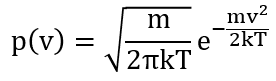

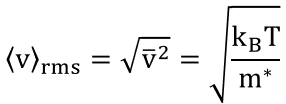

probability vs. speed [ms/s]


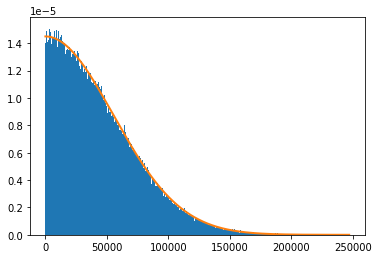

In [4]:
# generate random velocities according to 1D Maxwell-Boltzmann distribution ...
velocity = generateVelocityMaxwellBoltzmann_1D(temperature=300.,size=250000)

counts, bins, __ = plt.hist(velocity, 500, density=True,label='simulation')

# for i in range(len(counts)):
#   print('{}\t{}'.format(bins[i],counts[i]))
# print('')

v = []
p = []

# calculate the theoretical curve ...
for i in range(len(counts)):
  p.append(2.*theoMaxwellBoltzmann_1D(v=bins[i],temperature=300.))
  v.append(bins[i])
          
  # print('{}\t{}'.format(v[i],p[i]))

print('probability vs. speed [ms/s]')
plt.plot(v,p,lw=2,label='model')
plt.legend(loc="upper left")
plt.show()

# (B) evaluation of the functionality:
# **3D Maxwell-Boltzmann distribution ...** 

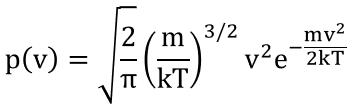

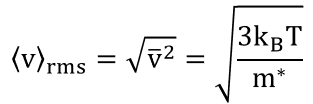

probability vs. speed [ms/s]


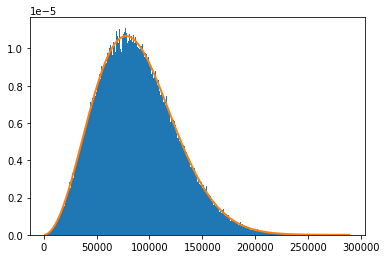

In [5]:
# generate random velocities according to 3D Maxwell-Boltzmann distribution ...
velocity = generateVelocityMaxwellBoltzmann(temperature=300.,size=250000)

counts, bins, __ = plt.hist(velocity, 500, density=True,label='simulation')

# for i in range(len(counts)):
#   print('{}\t{}'.format(bins[i],counts[i]))
# print('')

v = []
p = []

# calculate the theoretical curve ...
for i in range(len(counts)):
  p.append(theoMaxwellBoltzmann(v=bins[i],temperature=300.))
  v.append(bins[i])
          
  # print('{}\t{}'.format(v[i],p[i]))

print('probability vs. speed [ms/s]')
plt.plot(v,p,lw=2,label='model')
plt.legend(loc="upper left")
plt.show()

# (C) evaluation of the functionality:
# **generation of uniformly distributed points onto the surface of a sphere required to mimick the isotropic scattering of the particle (sphere point picking problem) ...**  

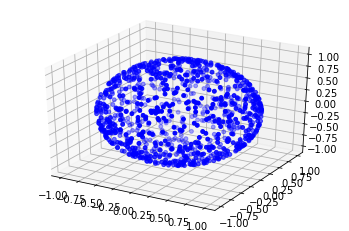

top view ...


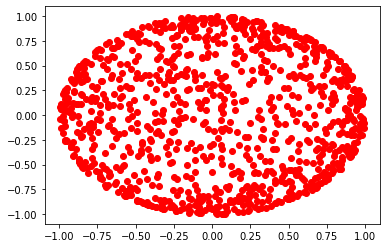

side view ...


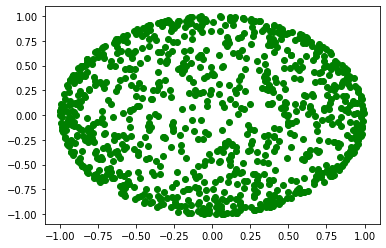

theta [2pi] vs. phi [pi] ...


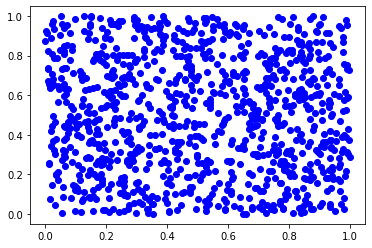

In [6]:
# 1000 samples onto the surface of a unit sphere (r = 1.) ...
x, y, z, theta, phi = sample(np.array([0.,0.,0.]), 1., 1000)

showSpherePoints(x,y,z)

print('top view ...')
plt.plot(x,y,'ro')
plt.show()

print('side view ...')
plt.plot(y,z,'go')
plt.show()

theta /= 2.*np.pi
phi /= np.pi

print('theta [2pi] vs. phi [pi] ...')
plt.plot(theta,phi,'bo')
plt.show()

# (D) evaluation of the functionality:
# **generation of uniformly distributed points inside the volume of a sphere (ball point picking problem) ...**

Roger Stafford (2021). Random Points in an n-Dimensional Hypersphere 

(https://www.mathworks.com/matlabcentral/fileexchange/9443-random-points-in-an-n-dimensional-hypersphere)

MATLAB Central File Exchange.

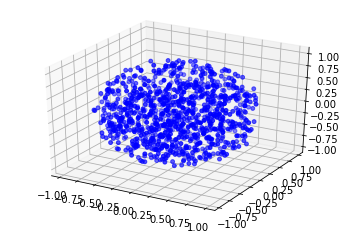

top view ...


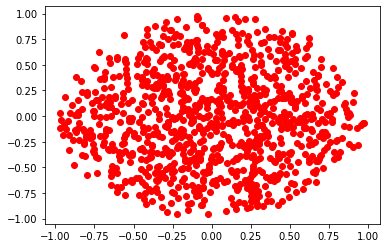

side view ...


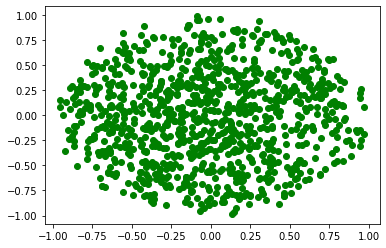

radial distribution ...


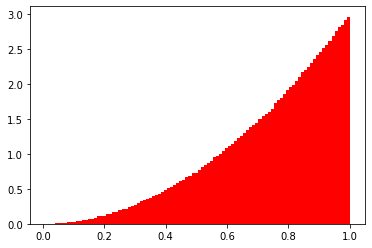

volume-segment normalized radial distribution ...


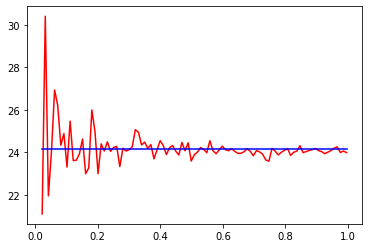

In [7]:
N = 1000000
xyz = sample_rad(np.array([0.,0.,0.]), 1., N)

x = [] 
y = [] 
z = []

r = []

for i in range(N):
  x.append(xyz[i][0])
  y.append(xyz[i][1])
  z.append(xyz[i][2])

  r.append(np.sqrt(xyz[i][0]*xyz[i][0]+xyz[i][1]*xyz[i][1]+xyz[i][2]*xyz[i][2]))

showSpherePoints(x[:1000],y[:1000],z[:1000])

print('top view ...')
plt.plot(x[:1000],y[:1000],'ro')
plt.show()

print('side view ...')
plt.plot(y[:1000],z[:1000],'go')
plt.show()

print('radial distribution ...')
counts, bins, __ = plt.hist(r, 100, density=True, color='r')
plt.show()

r_binned = []
counts_Vnorm = []

for i in range(1,len(counts)):
  r_min = bins[i]
  r_max = bins[i+1]

  V = (4/3)*np.pi*(r_max**3-r_min**3)

  r_binned.append(r_min + 0.5*(r_max-r_min))
  counts_Vnorm.append(counts[i]/V)

print('volume-segment normalized radial distribution ...')
plt.plot(r_binned,counts_Vnorm,'r')

m_r = [r_binned[0],r_binned[len(r_binned)-1]]
m_n = [sum(counts_Vnorm)/len(r_binned),sum(counts_Vnorm)/len(r_binned)]

plt.plot(m_r,m_n,'b-')
plt.show()

# The simplest one dimensional problem:
# **1D random walk**

In [9]:
def random_walk_1D(number_of_events=10000, 
                   ambient_temperature_in_K=300.,  
                   decay_in_ps=110.,              # Cu
                   D_in_cm2_per_s=1.5,            # Cu (rough estimate: projection of 3D into the 1D random walk) 
                   use_constant_velocity=True,    # if True: velocities generated according to the Maxwell-Boltzmann distribution (False: v-rms of Maxwell-Boltzmann distribution)
                   use_constant_time=False,       # if True: exponential decay according to exp(-t/'decay_in_ps') (False: 'decay_in_ps' = const.)
                   m_dev_N_limit = 1.):           # values above this level will be ignored
  seed()

  # e+ ...
  effect_mass = 1.5*scipy.constants.electron_mass

  # the diffusion constant and the mean path length just serve as a rough estimate to project the 3D case on a 1D random walk ...  

  # temperature dependence of diffusion constant ...
  D_in_cm2_per_s *= (ambient_temperature_in_K/300.)**(-0.63) # cm²/s

  mean_path_length_in_nm = 1e9*0.0001*(2.*D_in_cm2_per_s/np.pi)*np.sqrt(effect_mass/(scipy.constants.k*ambient_temperature_in_K)) # nm
  
  # stores the exp-distributed individual lifetimes ...
  if not use_constant_time:
    t_distribution = scipy.random.exponential(decay_in_ps,number_of_events) # ps

  # generates the velocities accoring to the Maxwell-Boltzmann distribution ...
  if not use_constant_velocity:
    mb_v_distr = generateVelocityMaxwellBoltzmann_1D(temperature=ambient_temperature_in_K,size=number_of_events) # m/s

  m_vec = []
  N_vec = []

  mN_ratio = np.zeros(1001) # in steps of ~0.1 %

  t_individual = decay_in_ps
  velocity = np.sqrt((1.*scipy.constants.k*ambient_temperature_in_K)/(effect_mass)) # 1-D <v-rms>

  for i in range(number_of_events):
      N = 0
      m = 0

      # 1) pick up individual lifetime from exp-distribution ...

      if not use_constant_time:
        t_individual = t_distribution[i]

      t = 0.

      # 2) pick up the particle velocity according to the Maxwell-Boltzmann distribution ...

      if not use_constant_velocity:
        velocity = mb_v_distr[i]

      delta_time = 1000.*mean_path_length_in_nm/velocity # ps

      est_cnt_steps = 15*int((t_individual*velocity*1e9/1e12)/mean_path_length_in_nm)
      direction = np.random.uniform(-1., 1., est_cnt_steps)

      a = -1
      while True:
        a += 1

        if a < est_cnt_steps:
          if direction[a] == 0:
            continue

          if direction[a] > 0: # + forth ..
            m += 1
          else: # - back ...
            m -= 1
        else:
          direction_single = np.random.uniform(-1., 1., 1)[0]

          if direction_single == 0:
            continue

          if direction_single >= 0: # + forth ..
            m += 1
          else: # - back ...
            m -= 1
          
        N += 1

        # increment time of life ...
        t += delta_time

        # check for annihilation ...
        if t >= t_individual:
          delta_t = t-t_individual
          delta_s = delta_t*velocity/1000.

          if m/N <= m_dev_N_limit and not m == 0:
            m_vec.append(m)
            m = np.abs(m)

            mN_ratio[int(1000.*m/N)] += 1
            
            N_vec.append(N)
            
          break

  print('steps in one direction (m) ...')

  min_m = np.amin(m_vec)
  max_m = np.amax(m_vec)

  min_N = np.amin(0)
  max_N = np.amax(N_vec)

  counts, bins, __ = plt.hist(m_vec,int(np.abs(max_m-min_m)/4),density=True,label="m")

  # for i in range(len(counts)):
  #   print('{}\t{}'.format(bins[i],counts[i]))
  # print('')

  # gaussian model fit sigma = sqrt(N)
  min_gaussian = np.amin(bins)
  max_gaussian = np.amax(bins)

  x = np.linspace(min_gaussian,max_gaussian) 
  norm_y = stats.norm.pdf(x,0.,np.sqrt(np.mean(N_vec)))

  plt.plot(x,norm_y,lw=2,label="model : stddev = sqrt(N)")
  plt.legend(loc="upper left")
  plt.show()

  # for i in range(len(norm_y)):
  #   print('{}\t{}'.format(x[i],norm_y[i]))
  # print('')

  if not use_constant_time:
    print('total steps (N) ...')

    counts, bins, __ = plt.hist(N_vec,1000,density=True)
    plt.show() 

    # for i in range(len(counts)):
    #   print('{}\t{}'.format(bins[i],counts[i])) 
    # print('')
  else:
    print('total steps (N) = {}'.format(np.mean(N_vec)))
    print('')

  print('distribution of m-N ratio ...')

  counts, bins, __ = plt.hist(mN_ratio,100,density=True)
  # plt.yscale('log')
  plt.show() 

  # mN_ratio/=sum(mN_ratio)
  # for i in range(len(mN_ratio)):
  #   print('{}\t{}'.format(i,mN_ratio[i]))

# (E) evaluation of functionality:
# **1D random walk** 
Eq. 12 Chandrasekhar 1943 : https://doi.org/10.1103/RevModPhys.15.1

steps in one direction (m) ...


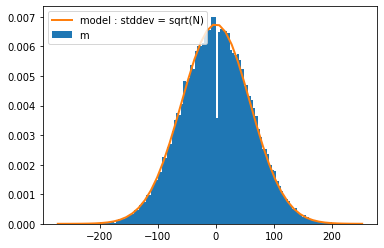

total steps (N) = 3492.0

distribution of m-N ratio ...


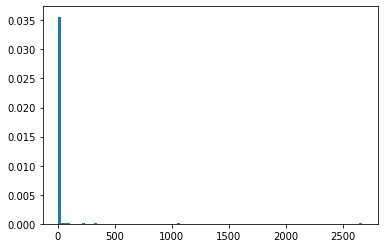

In [10]:
random_walk_1D(number_of_events=50000, 
               ambient_temperature_in_K=300., 
               decay_in_ps=110.,              # Cu
               D_in_cm2_per_s=1.5,            # Cu  
               use_constant_velocity=True,    # v-rms = const.
               use_constant_time=True,        # 'decay_in_ps' = const.
               m_dev_N_limit=1.)              # accept all m-N ratios ...

# The three dimensional problem applied to fine-grained spherical-shaped specimens:
# **3D random walk**

* probability p of finding a particle in between the region r1 and r2 after a constant time of life t **(Eq. 1)**

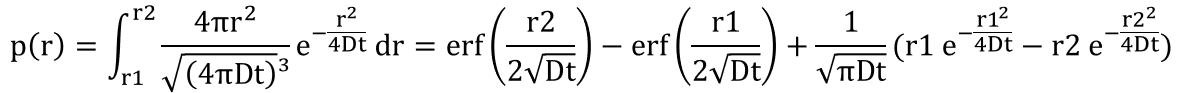

In [11]:
 def diffusionEq3D(D_in_cm2_per_s=1.5, # Cu 
                  r1_in_nm=0.0,
                  r2_in_nm=0.1,
                  time_in_ps=110.):
  inner = (r1_in_nm*1e-9)*np.exp(-0.25*((r1_in_nm*1e-9)**2)/(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))-(r2_in_nm*1e-9)*np.exp(-0.25*((r2_in_nm*1e-9)**2)/(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))

  return scipy.special.erf((0.5*(r2_in_nm*1e-9))/np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))-scipy.special.erf((0.5*(r1_in_nm*1e-9))/np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))+(1./np.sqrt(np.pi*D_in_cm2_per_s*1e-4*time_in_ps*1e-12))*inner


* probability p of finding a particle in between the region r1 and r2 considering an exponentially distributed lifetime **(Eq. 2)**

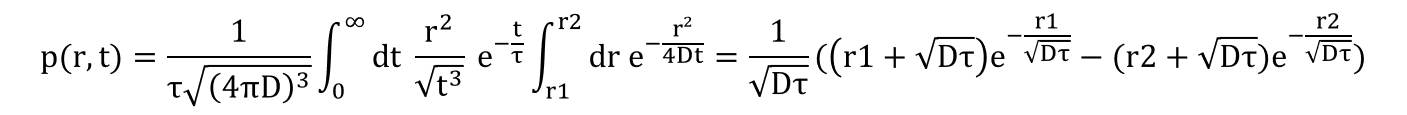

In [12]:
def diffusionEqExpTimeDistr3D(D_in_cm2_per_s=1.5, # Cu 
                              r1_in_nm=0.0,
                              r2_in_nm=0.1,
                              time_in_ps=110.):
  inner = (r1_in_nm*1e-9 + np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))*np.exp(-(r1_in_nm*1e-9)/np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12)) - (r2_in_nm*1e-9 + np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))*np.exp(-(r2_in_nm*1e-9)/np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))

  return (1./(time_in_ps*1e-12))*np.sqrt((time_in_ps*1e-12)/(D_in_cm2_per_s*1e-4))*inner

* probability p of finding a particle in between the region x1 and x2 considering an exponentially distributed lifetime **(Eq. 3)**

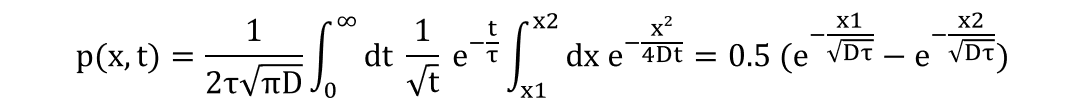

In [13]:
def diffusionEqExpTimeDistr1D(D_in_cm2_per_s=1.5, # Cu 
                  x1_in_nm=0.0,
                  x2_in_nm=0.1,
                  time_in_ps=110.):
  return 0.5*(np.exp(-x1_in_nm*1e-9/(np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12)))-np.exp(-x2_in_nm*1e-9/(np.sqrt(D_in_cm2_per_s*1e-4*time_in_ps*1e-12))))

* **method to determine the fraction of particles reaching the surface of the spherical-shaped grains**
* **this routine does not consider thermal vacancies**

In [28]:
def determine_fraction_of_particles_reaching_the_surface(number_of_events=50000, 
                                           ambient_temperature_in_K=300., 
                                           decay_in_ps=110.,                     # Cu
                                           D_in_cm2_per_s=1.5,                   # Cu (= D_zero -> this value will be scaled by the temperature 'ambient_temperature_in_K')
                                           mean_grain_radius_in_nm=1000.,        # if set to negative values grains of infinite size will be generated while each particles is forced to start from (0,0,0) ...
                                           poisson_distributed_grains=False, 
                                           gaussian_distributed_grains=False, 
                                           stddev_grain_radius_in_nm=50.,        # in case of 'gaussian_distributed_grains' =  True
                                           start_at_center=False,                # if True: all particles start at (0,0,0)
                                           discretize_motion=False,              # if True: particle is only allowed to move along the axis in a constant step width
                                           use_constant_time=False,              # if True: each particle will be alive the same given time 'decay_in_ps'
                                           use_constant_velocity=False,          # if True: the v-rms of the Maxwell-Boltzmann distribution will be taken (False: velocities are generated randomly according to the Maxwell-Boltzmann distribution)
                                           verbose=1):                           # manages the debug output ...
  infinity_size = False

  if mean_grain_radius_in_nm < 0:
    infinity_size = True
    mean_grain_radius_in_nm = 99999999999999
    poisson_distributed_grains = False
    gaussian_distributed_grains = False
    start_at_center = True

  seed()

  effect_mass = 1.5*scipy.constants.electron_mass

  # temperature dependence of diffusion constant
  D_in_cm2_per_s *= (ambient_temperature_in_K/300.)**(-0.63)

  mean_path_length_in_nm = 1e9*0.0001*D_in_cm2_per_s*np.sqrt(3.*effect_mass/(scipy.constants.k*ambient_temperature_in_K)) # nm 

  # stores the particle-size distribution ...
  grain_size_distr = np.zeros(number_of_events)

  if poisson_distributed_grains:
    grain_size_distr = scipy.random.poisson(mean_grain_radius_in_nm,number_of_events)
  elif gaussian_distributed_grains:
    grain_size_distr = scipy.random.normal(mean_grain_radius_in_nm,stddev_grain_radius_in_nm,number_of_events)
  else:
    grain_size_distr[:] = mean_grain_radius_in_nm

  # stores the exp-distributed individual lifetimes ...
  t_distribution = scipy.random.exponential(decay_in_ps, number_of_events) # ps

  # generates the velocities according to the Maxwell-Boltzmann distribution ...
  mb_v_distr = generateVelocityMaxwellBoltzmann(temperature=ambient_temperature_in_K,size=number_of_events) # m/s

  # zero the fraction of particles reaching the surface or annihilate inside the volume ...
  fraction_counter   = 0
  annihilated_inside = 0

  # stores the diffusion paths ...
  diffusion_path_int  = [] # diffusion path length
  diffusion_path_diff = [] # mean-root-square diffusion length

  if verbose >= 2:
    s_vec = [] # stores the individual steps of track ...

  t_vec = [] # stores the individual lifetimes not reaching the surface (reduced bulk liftime)...

  if verbose >= 2:
    mb_distr = [] # stores the individual velocities according to the Maxwell-Boltzmann distribution ...

    x_proj = [] # stores the start-point (x) 
    y_proj = [] # stores the start-point (y) 
    z_proj = [] # stores the start-point (z)

    x_proj_end = [] # stores the end-point (x) 
    y_proj_end = [] # stores the end-point (y) 
    z_proj_end = [] # stores the end-point (z) 

  x = y = z = 0.

  if not start_at_center:
    p_rnd = sample_rad(np.array([0.,0.,0.]), 1., number_of_events)

  if start_at_center:
    r_stop_vec = []

  if use_constant_time:
    t_individual = decay_in_ps

  velocity = np.sqrt((3.*scipy.constants.k*ambient_temperature_in_K)/(effect_mass)) # v-rms according to the Maxwell-Boltzmann distribution in 3D ...
    
  for i in range(number_of_events):
      # 0) pick up grain-size ...

      r = grain_size_distr[i]

      # 1) pick up individual lifetime from exp-distribution ...

      if not use_constant_time:
        t_individual = t_distribution[i]

      # 2) determine start-point (= end of thermalization)
      
      if not start_at_center:
        x = p_rnd[i][0]*r
        y = p_rnd[i][1]*r
        z = p_rnd[i][2]*r
      else:
        x = y = z = 0.  

      x_start = x
      y_start = y
      z_start = z

      if verbose >= 2:
        x_proj.append(x_start)
        y_proj.append(y_start)
        z_proj.append(z_start)

      L = 0. # zero integral diffusion path length ...
      x_last = x_start
      y_last = y_start
      z_last = z_start

      fps = False
      t = 0. # ps // zero integral lifetime of particle ...

      # 3) pick up the particle velocity according to the Maxwell-Boltzmann distribution ...

      if not use_constant_velocity:
        velocity = mb_v_distr[i]

      if verbose >= 2:
        mb_distr.append(velocity)
        
      # 4) run the diffusion process ...

      if verbose >= 2:
        track_steps_x = []
        track_steps_y = []
        track_steps_z = []

        track_steps_x_0 = []
        track_steps_y_0 = []
        track_steps_z_0 = []

      if verbose >= 2:
        if annihilated_inside <= 5: # only show up the first 5 tracks ...
          track_steps_x.append(x_start)
          track_steps_y.append(y_start)
          track_steps_z.append(z_start)

      # generate new step lengths from exponential distribution ...
      est_gen_cnt = 10*int(velocity*t_individual*1e-12/(mean_path_length_in_nm*1e-9)) # [#]

      iso_angle_vec = scipy.random.exponential(mean_path_length_in_nm, est_gen_cnt)
      x_i_rnd, y_i_rnd, z_i_rnd, __, __ = sample(np.array([0.,0.,0.]), 1., est_gen_cnt) 

      a = -1
      x_i = y_i = z_i = 0.
      
      step_cnt = 0
      
      while True:
        a += 1

        # generate new step length from exponential distribution ...
        if a < est_gen_cnt:
          rad_step = iso_angle_vec[a] 
        else:
          rad_step = scipy.random.exponential(mean_path_length_in_nm, 1)[0]

        if verbose >= 2:
          s_vec.append(rad_step)

        if discretize_motion:
          direction = np.random.uniform(0, 6, 1)[0] # six discrete directions in 3D ...
          rad_step  = mean_path_length_in_nm
      
        if a < est_gen_cnt:
          if discretize_motion:
            if direction >= 0 and direction <= 1:
              x_i_rnd[a] = 1.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = 0.0
            elif direction >= 1 and direction <= 2:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = 1.0
              z_i_rnd[a] = 0.0
            elif direction >= 2 and direction <= 3:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = 1.0
            elif direction >= 3 and direction <= 4:
              x_i_rnd[a] = -1.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = 0.0
            elif direction >= 4 and direction <= 5:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = -1.0
              z_i_rnd[a] = 0.0
            elif direction >= 5 and direction <= 6:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = -1.0
 
          x_i = x_i_rnd[a]*rad_step
          y_i = y_i_rnd[a]*rad_step
          z_i = z_i_rnd[a]*rad_step

          if verbose >= 2:
            if annihilated_inside <= 5:
              track_steps_x_0.append(x_i_rnd[a])
              track_steps_y_0.append(y_i_rnd[a])
              track_steps_z_0.append(z_i_rnd[a])

          x += x_i
          y += y_i
          z += z_i
        else:
          if not discretize_motion:
            x_i, y_i, z_i, __, __ = sample(np.array([0.,0.,0.]), rad_step, 1)
          else:
            x_i_rnd, y_i_rnd, z_i_rnd, __, __ = sample(np.array([0.,0.,0.]), 1., 1)

          if discretize_motion:
            if direction >= 0 and direction <= 1:
              x_i_rnd[0] = 1.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = 0.0
            elif direction >= 1 and direction <= 2:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = 1.0
              z_i_rnd[0] = 0.0
            elif direction >= 2 and direction <= 3:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = 1.0
            elif direction >= 3 and direction <= 4:
              x_i_rnd[0] = -1.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = 0.0
            elif direction >= 4 and direction <= 5:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = -1.0
              z_i_rnd[0] = 0.0
            elif direction >= 5 and direction <= 6:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = -1.0

            x_i = x_i_rnd[0]*rad_step
            y_i = y_i_rnd[0]*rad_step
            z_i = z_i_rnd[0]*rad_step

            x += x_i
            y += y_i
            z += z_i
          else:
            x += x_i[0]
            y += y_i[0]
            z += z_i[0]

          if verbose >= 2:
            if annihilated_inside <= 5:
              if not discretize_motion:
                track_steps_x_0.append(x_i[0])
                track_steps_y_0.append(y_i[0])
                track_steps_z_0.append(z_i[0])
              else:
                track_steps_x_0.append(x_i_rnd[0])
                track_steps_y_0.append(y_i_rnd[0])
                track_steps_z_0.append(z_i_rnd[0])

        L += np.sqrt((x-x_last)*(x-x_last)+(y-y_last)*(y-y_last)+(z-z_last)*(z-z_last))

        step_cnt += 1

        if verbose >= 2:
          if annihilated_inside <= 5: # only show up the first 5 tracks ...
            track_steps_x.append(x)
            track_steps_y.append(y)
            track_steps_z.append(z)

        # increment time of life ...
        t += 1000.*rad_step/(velocity) # ps

        # check if the surface is reached or the particle did annihilate inside the volume ...
        if np.sqrt(x*x + y*y + z*z) >= r:
          fps = True

          break

        # check for annihilation inside the volume ...
        if t >= t_individual:
          # correct for overlapping time ...
          delta_t = t-t_individual
          delta_s = delta_t*velocity/1000.

          inv_abs_unit_vec = 1./np.sqrt((x-x_last)*(x-x_last)+(y-y_last)*(y-y_last)+(z-z_last)*(z-z_last))

          unit_vec_x = inv_abs_unit_vec*(- x_last + x)
          unit_vec_y = inv_abs_unit_vec*(- y_last + y)
          unit_vec_z = inv_abs_unit_vec*(- z_last + z) 

          x_last += delta_s*unit_vec_x
          y_last += delta_s*unit_vec_y
          z_last += delta_s*unit_vec_z

          diffusion_path_int.append(L-delta_s)
          diffusion_path_diff.append((x_last-x_start)*(x_last-x_start)+(y_last-y_start)*(y_last-y_start)+(z_last-z_start)*(z_last-z_start))
          t_vec.append(t_individual)

          if start_at_center:
            r_stop_vec.append(np.sqrt(x_last*x_last+y_last*y_last+z_last*z_last))

            if verbose >= 2:
              x_proj_end.append(x_last)
              y_proj_end.append(y_last)
              z_proj_end.append(z_last)
            
          annihilated_inside += 1

          break

        x_last = x
        y_last = y
        z_last = z

      # surface reached ?
      if fps:
        fraction_counter = fraction_counter + 1

      if verbose >= 2:
        if annihilated_inside <= 5: # only show up the first 5 tracks ...
          if not infinity_size:
            showSphereWithDiffusionPath(r,[track_steps_x,track_steps_y,track_steps_z])

          print('1D projection of individual random-walk steps')
          plt.plot(track_steps_x, track_steps_y, 'b-',label='x-y plane')
          plt.plot(track_steps_y, track_steps_z, 'r-',label='y-z plane')
          plt.plot(track_steps_x, track_steps_z, 'g-',label='x-z plane')
          plt.legend(loc="upper left")
          plt.show()

          # showSpherePoints(track_steps_x_0,track_steps_y_0,track_steps_z_0)

  # print out results ...
  if verbose >= 1:
    print('ambient-temperature                 = {} K'.format(ambient_temperature_in_K))
    print('diffusion-constant                  = {} cm²/s'.format(D_in_cm2_per_s))
    print('Maxwell-Boltzmann >> mean <v_mean>  = {} m/s [theory: {} m/s]'.format(np.mean(mb_v_distr),np.sqrt((8.*scipy.constants.k*ambient_temperature_in_K)/(np.pi*effect_mass))))
    print('Maxwell-Boltzmann >> rms  <v_rms>   = {} m/s [theory: {} m/s]'.format(np.sqrt(np.mean(mb_v_distr**2)),np.sqrt((3.*scipy.constants.k*ambient_temperature_in_K)/(effect_mass))))

    if not infinity_size:
      print('fraction of e+ reaching the surface = {} %'.format(100.*fraction_counter/number_of_events))

    print('mean diffusion length               = {} nm [theory: {} nm]'.format(np.sqrt(np.mean(diffusion_path_diff)), 1e9*np.sqrt(6.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))) 
    print('mean integral diffusion path length = {} nm'.format(np.mean(diffusion_path_int)))
    print('')

  if verbose >= 2:
      # plot the grain-size distribution ...
    if poisson_distributed_grains or gaussian_distributed_grains:
        print('grain-size distribution [nm]')
        plt.hist(grain_size_distr, 60, density=True)
        plt.show()

    # plot distribution of individual steps ...
    print('diffusion-step distribution [nm]: mean {} nm [theory: {} nm]'.format(np.mean(s_vec),mean_path_length_in_nm))
    plt.hist(s_vec, 120, density=True)
    plt.yscale('log')
    plt.show()

    # plot distributions of individual lifetimes annihilated inside the volume of the grains ...
    print('distribution of individual lifetimes [ps]: mean {} ps [theory: {} ps]'.format(np.mean(t_vec),decay_in_ps))
    plt.hist([t_distribution,t_vec], 120, density=True)
    plt.yscale('log')
    plt.show()

    if not start_at_center:
      # plot the (1D-projected) start-points ...
      print('distribution of start-points')
      plt.plot(x_proj, y_proj, 'bo',label='x-y plane')
      plt.plot(y_proj, z_proj, 'ro',label='y-z plane')
      plt.plot(x_proj, z_proj, 'go',label='x-z plane')
      plt.legend(loc="upper left")
      plt.show()

      showSpherePoints(x_proj, y_proj, z_proj)

    if start_at_center and infinity_size:
      # plot the end point radial distribution ...
      print('radial distribution of diffusion end-points')
      r_max = np.amax(r_stop_vec)

      counts, bins, __ = plt.hist(r_stop_vec, int(r_max/8), density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')  

      if use_constant_velocity:
        x = []
        y = []

        r1 = 0.

        for i in range(int(r_max)):
          r2 = r1+1.

          if not use_constant_time:
            y.append(diffusionEqExpTimeDistr3D(D_in_cm2_per_s,r1,r2,decay_in_ps))
          else:
            y.append(diffusionEq3D(D_in_cm2_per_s,r1,r2,decay_in_ps)) 

          x.append(r1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          r1=r2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")

        # print('') 
      plt.show()

      min_x = np.amin(x_proj_end)
      max_x = np.amax(x_proj_end)

      min_y = np.amin(y_proj_end)
      max_y = np.amax(y_proj_end)

      min_z = np.amin(z_proj_end)
      max_z = np.amax(z_proj_end)

      max_vec = np.amax([max_z,max_y,max_x])
      min_vec = np.amin([min_z,min_y,min_x])

      print('distribution of end-points along the x-axis ...')
      counts, bins, __ = plt.hist(x_proj_end,int(np.abs(max_vec-min_vec)/4),density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')

      min_gaussian = np.amin(bins)
      max_gaussian = np.amax(bins)

      if use_constant_time and use_constant_velocity:
        x = np.linspace(min_gaussian,max_gaussian) 
        norm_y = stats.norm.pdf(x,0.,1e9*np.sqrt(2.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))

        # for i in range(len(norm_y)):
        #   print('{}\t{}'.format(x[i],norm_y[i]))

        plt.plot(x,norm_y,lw=2,label='model')
        plt.legend(loc="upper left")
      elif not use_constant_time and use_constant_velocity:
        x = []
        y = []

        x1 = 0.
        for i in range(int(np.amax(x_proj_end))):
          x2 = x1+1.

          y.append(diffusionEqExpTimeDistr1D(D_in_cm2_per_s,x1,x2,decay_in_ps))
          x.append(x1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          x1=x2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")
      plt.show()

      print('distribution of end-points along the y-axis ...')
      counts, bins, __ = plt.hist(y_proj_end,int(np.abs(max_vec-min_vec)/4),density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')

      min_gaussian = np.amin(bins)
      max_gaussian = np.amax(bins)

      if use_constant_time and use_constant_velocity:
        x = np.linspace(min_gaussian,max_gaussian) 
        norm_y = stats.norm.pdf(x,0.,1e9*np.sqrt(2.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))

        # for i in range(len(norm_y)):
        #   print('{}\t{}'.format(x[i],norm_y[i]))

        plt.plot(x,norm_y,lw=2,label='model')
        plt.legend(loc="upper left")
      elif not use_constant_time and use_constant_velocity:
        x = []
        y = []

        x1 = 0.
        for i in range(int(np.amax(y_proj_end))):
          x2 = x1+1.

          y.append(diffusionEqExpTimeDistr1D(D_in_cm2_per_s,x1,x2,decay_in_ps))
          x.append(x1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          x1=x2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")
      plt.show()

      print('distribution of end-points along the z-axis ...')
      counts, bins, __ = plt.hist(z_proj_end,int(np.abs(max_vec-min_vec)/4),density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')

      min_gaussian = np.amin(bins)
      max_gaussian = np.amax(bins)

      if use_constant_time and use_constant_velocity:
        x = np.linspace(min_gaussian,max_gaussian) 
        norm_y = stats.norm.pdf(x,0.,1e9*np.sqrt(2.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))

        # for i in range(len(norm_y)):
        #   print('{}\t{}'.format(x[i],norm_y[i]))

        plt.plot(x,norm_y,lw=2,label='model')
        plt.legend(loc="upper left")
      elif not use_constant_time and use_constant_velocity:
        x = []
        y = []

        x1 = 0.
        for i in range(int(np.amax(z_proj_end))):
          x2 = x1+1.

          y.append(diffusionEqExpTimeDistr1D(D_in_cm2_per_s,x1,x2,decay_in_ps))
          x.append(x1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          x1=x2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")
      plt.show()

  return 100.*fraction_counter/number_of_events, np.mean(t_vec)

# vary grain-size ...
def vary_grainsize_for_fine_grained_spheres(number_of_events=10000, 
                                            ambient_temperature_in_K=300., 
                                            decay_in_ps=110., # Cu
                                            D_in_cm2_per_s=1.5, # Cu
                                            mean_grain_radius_in_nm=[100.,10000,1000.], 
                                            poisson_distributed_grains=False, 
                                            gaussian_distributed_grains=False, 
                                            stddev_grain_radius_in_nm=50.,
                                            start_at_center=False,
                                            discretize_motion=False,
                                            use_constant_time=False,
                                            use_constant_velocity=False,
                                            verbose=0):
  grain_r_vec           = []
  grain_fps_mc_vec      = []
  grain_tau_mean_mc_vec = []

  radius = np.arange(mean_grain_radius_in_nm[0], mean_grain_radius_in_nm[1], mean_grain_radius_in_nm[2])

  for i in range(len(radius)):
    fps_mc, tau_mean = determine_fraction_of_particles_reaching_the_surface(number_of_events=number_of_events, 
                                                              ambient_temperature_in_K=ambient_temperature_in_K, 
                                                              decay_in_ps=decay_in_ps, 
                                                              D_in_cm2_per_s=D_in_cm2_per_s, 
                                                              mean_grain_radius_in_nm=radius[i], 
                                                              poisson_distributed_grains=poisson_distributed_grains, 
                                                              gaussian_distributed_grains=gaussian_distributed_grains, 
                                                              stddev_grain_radius_in_nm=stddev_grain_radius_in_nm,
                                                              start_at_center=start_at_center,
                                                              discretize_motion=discretize_motion,
                                                              use_constant_time=use_constant_time,
                                                              use_constant_velocity=use_constant_velocity,
                                                              verbose=verbose)
    # print('{}\t{}\t{}'.format(radius[i],fps_mc,tau_mean))
    grain_r_vec.append(radius[i])
    grain_fps_mc_vec.append(fps_mc)
    grain_tau_mean_mc_vec.append(tau_mean)
  
  return grain_r_vec, grain_fps_mc_vec, grain_tau_mean_mc_vec

# (F) evaluation of functionality:
# **3D random walk of particles with constant lifetimes: Eq 1** 
# infinitely extended sphere/constant start-points at center of sphere 

1D projection of individual random-walk steps


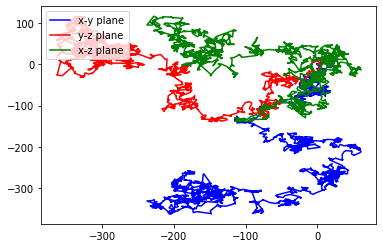

1D projection of individual random-walk steps


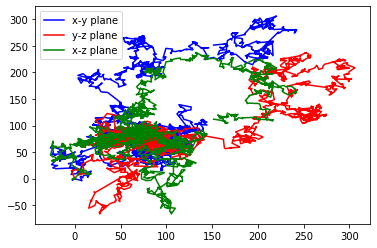

1D projection of individual random-walk steps


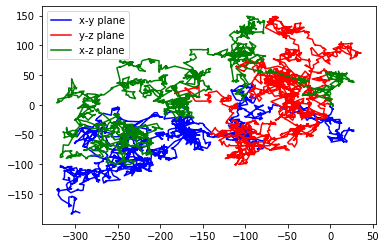

1D projection of individual random-walk steps


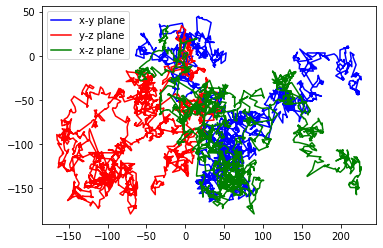

1D projection of individual random-walk steps


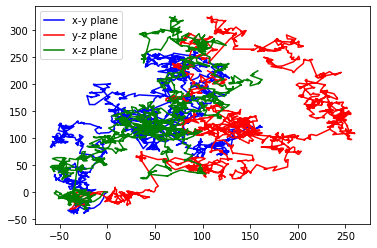

ambient-temperature                 = 300.0 K
diffusion-constant                  = 1.5 cm²/s
Maxwell-Boltzmann >> mean <v_mean>  = 87512.12906895943 m/s [theory: 87858.1791875279 m/s]
Maxwell-Boltzmann >> rms  <v_rms>   = 95079.18337353555 m/s [theory: 95361.4330249504 m/s]
mean diffusion length               = 314.4295942064585 nm [theory: 314.6426544510455 nm]
mean integral diffusion path length = 10489.757632744542 nm

diffusion-step distribution [nm]: mean 4.720102438730649 nm [theory: 4.7188888183157 nm]


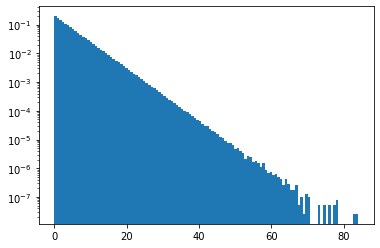

distribution of individual lifetimes [ps]: mean 110.0 ps [theory: 110.0 ps]


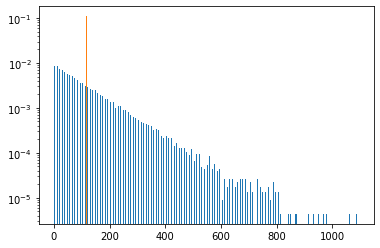

radial distribution of diffusion end-points


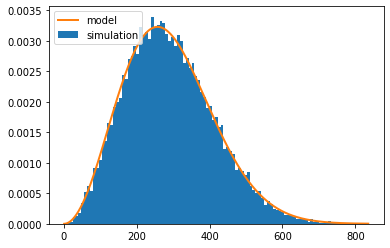

distribution of end-points along the x-axis ...


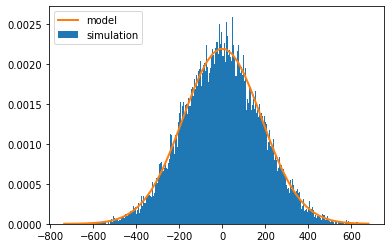

distribution of end-points along the y-axis ...


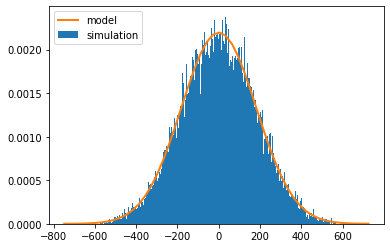

distribution of end-points along the z-axis ...


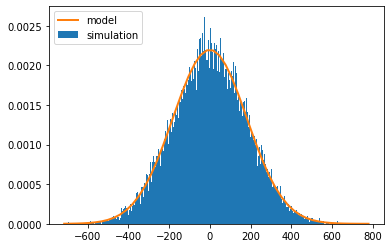

In [25]:
__, __ = determine_fraction_of_particles_reaching_the_surface(number_of_events=25000, 
                                           ambient_temperature_in_K=300., 
                                           decay_in_ps=110.,                     # Cu
                                           D_in_cm2_per_s=1.5,                   # Cu 
                                           mean_grain_radius_in_nm=-1.,          # infinitely extended sphere ...       
                                           start_at_center=True,                
                                           discretize_motion=False,             
                                           use_constant_time=True,               
                                           use_constant_velocity=True,           # v-rms = const.
                                           verbose=2)

# (G) evaluation of functionality:
# **3D random walk of particles with exponentially distr. lifetimes: Eq 2/3** 
# infinitely extended sphere/constant start-points at center of sphere 


1D projection of individual random-walk steps


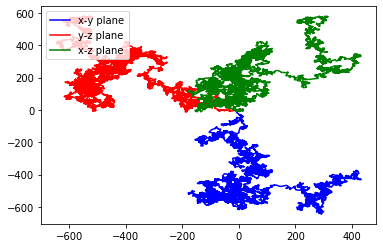

1D projection of individual random-walk steps


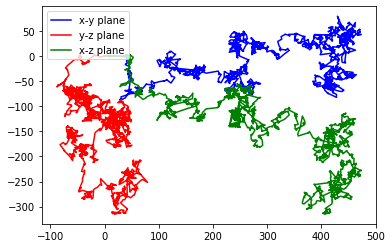

1D projection of individual random-walk steps


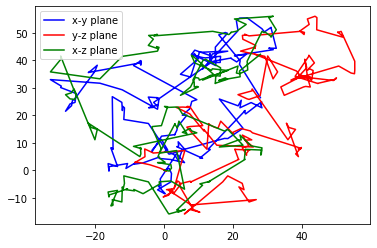

1D projection of individual random-walk steps


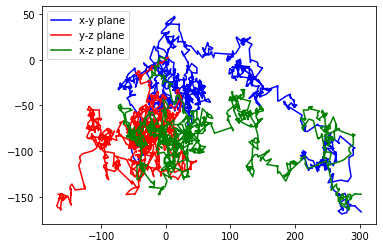

1D projection of individual random-walk steps


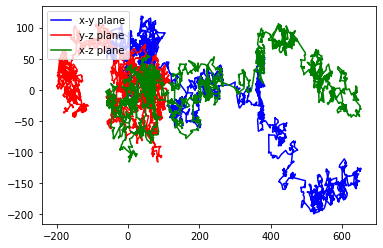

ambient-temperature                 = 300.0 K
diffusion-constant                  = 1.5 cm²/s
Maxwell-Boltzmann >> mean <v_mean>  = 87777.37991131541 m/s [theory: 87858.1791875279 m/s]
Maxwell-Boltzmann >> rms  <v_rms>   = 95248.48126197042 m/s [theory: 95361.4330249504 m/s]
mean diffusion length               = 315.5579284720075 nm [theory: 314.6426544510455 nm]
mean integral diffusion path length = 10474.982588625717 nm

diffusion-step distribution [nm]: mean 4.7191313111232605 nm [theory: 4.7188888183157 nm]


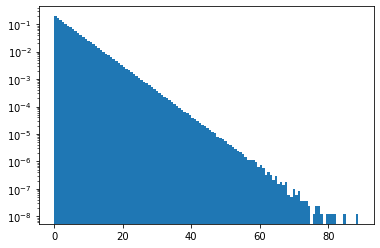

distribution of individual lifetimes [ps]: mean 109.84506268781676 ps [theory: 110.0 ps]


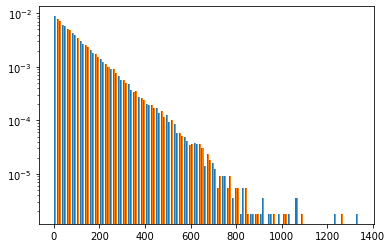

radial distribution of diffusion end-points


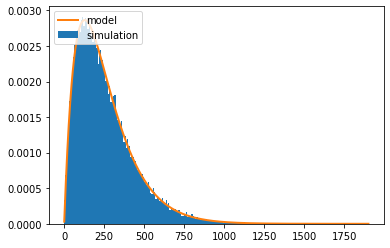

distribution of end-points along the x-axis ...


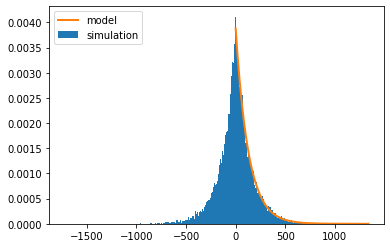

distribution of end-points along the y-axis ...


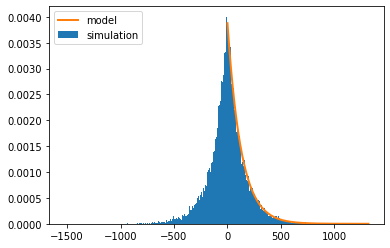

distribution of end-points along the z-axis ...


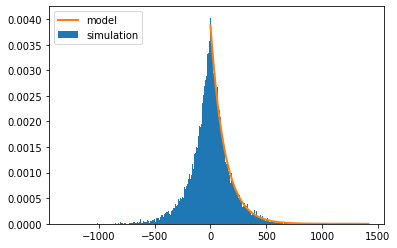

In [26]:
__, __ = determine_fraction_of_particles_reaching_the_surface(number_of_events=50000, 
                                           ambient_temperature_in_K=300., 
                                           decay_in_ps=110.,                     # Cu
                                           D_in_cm2_per_s=1.5,                   # Cu 
                                           mean_grain_radius_in_nm=-1.,          # infinitely extended sphere ...       
                                           start_at_center=True,                
                                           discretize_motion=False,             
                                           use_constant_time=False,               
                                           use_constant_velocity=True,           # v-rms = const.
                                           verbose=2)

# **Results: fraction of particles reaching the surface vs. grain-size**
# example: fine-grained Cu

start at center (0,0,0) ...


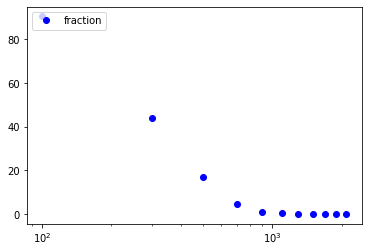

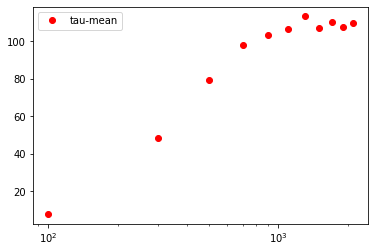

random start points ...


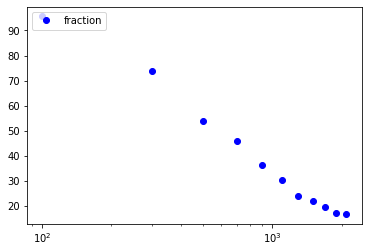

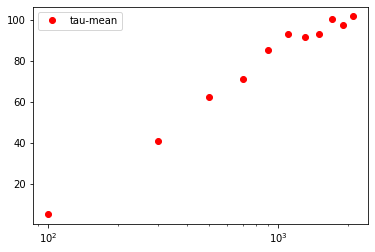

In [31]:
# (1) start at center ...
r, fps, tau_mean = vary_grainsize_for_fine_grained_spheres(number_of_events=2000, 
                                            ambient_temperature_in_K=300., 
                                            decay_in_ps=110., # Cu
                                            D_in_cm2_per_s=1.5, # Cu
                                            mean_grain_radius_in_nm=[100.,2200,200.], 
                                            poisson_distributed_grains=False, 
                                            gaussian_distributed_grains=False, 
                                            stddev_grain_radius_in_nm=50.,
                                            start_at_center=True,
                                            discretize_motion=False,
                                            use_constant_time=False,
                                            use_constant_velocity=True,
                                            verbose=0)

print('start at center (0,0,0) ...')
plt.plot(r,fps,'bo',label='fraction')
plt.xscale('log')
plt.legend(loc="upper left")
plt.show()

plt.plot(r,tau_mean,'ro',label='tau-mean')
plt.xscale('log')
plt.legend(loc="upper left")
plt.show()


# (2) random start-points ...
r, fps, tau_mean = vary_grainsize_for_fine_grained_spheres(number_of_events=2000, 
                                            ambient_temperature_in_K=300., 
                                            decay_in_ps=110., # Cu
                                            D_in_cm2_per_s=1.5, # Cu
                                            mean_grain_radius_in_nm=[100.,2200,200.], 
                                            poisson_distributed_grains=False, 
                                            gaussian_distributed_grains=False, 
                                            stddev_grain_radius_in_nm=50.,
                                            start_at_center=False,
                                            discretize_motion=False,
                                            use_constant_time=False,
                                            use_constant_velocity=True,
                                            verbose=0)

print('random start points ...')
plt.plot(r,fps,'bo',label='fraction')
plt.xscale('log')
plt.legend(loc="upper left")
plt.show()

plt.plot(r,tau_mean,'ro',label='tau-mean')
plt.xscale('log')
plt.legend(loc="upper left")
plt.show()

* **method to determine the fraction of particles reaching the surface of the spherical-shaped grains considering thermal vacancies**

In [36]:
def determine_fraction_of_particles_reaching_the_surface_considering_void_like_defects(number_of_events=50000, 
                                           ambient_temperature_in_K=300., 
                                           decay_in_ps=110.,                           # Cu
                                           D_in_cm2_per_s=1.5,                         # Cu (= D_zero -> this value will be scaled by the temperature 'ambient_temperature_in_K')
                                           mean_grain_radius_in_nm=1000.,              # if set to negative values grains of infinite size will be generated while each particles is forced to start from (0,0,0) ...
                                           poisson_distributed_grains=False, 
                                           gaussian_distributed_grains=False, 
                                           stddev_grain_radius_in_nm=50.,              # in case of 'gaussian_distributed_grains' = True
                                           start_at_center=False,                      # if True: all particles start at (0,0,0)
                                           discretize_motion=False,                    # if True: particle is only allowed to move along the axis in a constant step width
                                           use_constant_time=False,                    # if True: each particle will be alive the same given time 'decay_in_ps'
                                           use_constant_velocity=False,                # if True: the v-rms of the Maxwell-Boltzmann distribution will be taken (False: velocities are generated randomly according to the Maxwell-Boltzmann distribution)
                                           concentration_of_voids=1e-4,                # volume fraction of voids [0,1]
                                           void_radius_of_interaction_in_Angstrom=1.4, # Cu // e.g. bonding distance ... 
                                           number_of_atoms_per_unit_cell=4,            # Cu // bcc:2, fcc:4, hcp:6
                                           volume_of_unit_cell_in_Angstrom3=3.615**3,  # Cu
                                           verbose=1):                                 # manages the debug output ...
  infinity_size = False

  if mean_grain_radius_in_nm < 0:
    infinity_size = True
    mean_grain_radius_in_nm = 99999999999999
    poisson_distributed_grains = False
    gaussian_distributed_grains = False
    start_at_center = True

  seed()

  effect_mass = 1.5*scipy.constants.electron_mass

  # temperature dependence of diffusion constant
  D_in_cm2_per_s *= (ambient_temperature_in_K/300.)**(-0.63)

  mean_path_length_in_nm = 1e9*0.0001*D_in_cm2_per_s*np.sqrt(3.*effect_mass/(scipy.constants.k*ambient_temperature_in_K)) # nm 

  # stores the particle-size distribution ...
  grain_size_distr = np.zeros(number_of_events)

  if poisson_distributed_grains:
    grain_size_distr = scipy.random.poisson(mean_grain_radius_in_nm,number_of_events)
  elif gaussian_distributed_grains:
    grain_size_distr = scipy.random.normal(mean_grain_radius_in_nm,stddev_grain_radius_in_nm,number_of_events)
  else:
    grain_size_distr[:] = mean_grain_radius_in_nm

  # stores the exp-distributed individual lifetimes ...
  t_distribution = scipy.random.exponential(decay_in_ps, number_of_events) # ps

  # generates the velocities according to the Maxwell-Boltzmann distribution ...
  mb_v_distr = generateVelocityMaxwellBoltzmann(temperature=ambient_temperature_in_K,size=number_of_events) # m/s

  # zero the fraction of particles reaching the surface or annihilate inside the volume ...
  fraction_counter   = 0
  annihilated_inside = 0
  void_trapped       = 0 # defects

  # stores the diffusion paths ...
  diffusion_path_int  = [] # diffusion path length
  diffusion_path_diff = [] # mean-root-square diffusion length

  if verbose >= 2:
    s_vec = [] # stores the individual steps of track ...

  t_vec = [] # stores the individual lifetimes not reaching the surface (reduced bulk liftime)...

  if verbose >= 2:
    mb_distr = [] # stores the individual velocities according to the Maxwell-Boltzmann distribution ...

    x_proj = [] # stores the start-point (x) 
    y_proj = [] # stores the start-point (y) 
    z_proj = [] # stores the start-point (z)

    x_proj_end = [] # stores the end-point (x) 
    y_proj_end = [] # stores the end-point (y) 
    z_proj_end = [] # stores the end-point (z) 

  x = y = z = 0.

  if not start_at_center:
    p_rnd = sample_rad(np.array([0.,0.,0.]), 1., number_of_events)

  if start_at_center:
    r_stop_vec = []

  if use_constant_time:
    t_individual = decay_in_ps

  velocity = np.sqrt((3.*scipy.constants.k*ambient_temperature_in_K)/(effect_mass)) # v-rms according to the Maxwell-Boltzmann distribution in 3D ...
    
  for i in range(number_of_events):
      # 0) pick up grain-size ...

      r = grain_size_distr[i]

      # distribute void-like defects homgeneously inside the volume of the sphere ...
      number_of_voids   = int(concentration_of_voids*number_of_atoms_per_unit_cell*((4/3)*np.pi*r*r*r*1e3)/volume_of_unit_cell_in_Angstrom3)
      void_distribution = sample_rad(np.array([0.,0.,0.]), r*10.-void_radius_of_interaction_in_Angstrom, number_of_voids) # [A]

      # 1) pick up individual lifetime from exp-distribution ...

      if not use_constant_time:
        t_individual = t_distribution[i]

      # 2) determine start-point (= end of thermalization)
      
      if not start_at_center:
        x = p_rnd[i][0]*r
        y = p_rnd[i][1]*r
        z = p_rnd[i][2]*r
      else:
        x = y = z = 0.  

      x_start = x
      y_start = y
      z_start = z

      if verbose >= 2:
        x_proj.append(x_start)
        y_proj.append(y_start)
        z_proj.append(z_start)

      L = 0. # zero integral diffusion path length ...
      x_last = x_start
      y_last = y_start
      z_last = z_start

      fps = False
      t = 0. # ps // zero integral lifetime of particle ...

      # 3) pick up the particle velocity according to the Maxwell-Boltzmann distribution ...

      if not use_constant_velocity:
        velocity = mb_v_distr[i]

      if verbose >= 2:
        mb_distr.append(velocity)
        
      # 4) run the diffusion process ...

      if verbose >= 2:
        track_steps_x = []
        track_steps_y = []
        track_steps_z = []

        track_steps_x_0 = []
        track_steps_y_0 = []
        track_steps_z_0 = []

      if verbose >= 2:
        if annihilated_inside <= 5: # only show up the first 5 tracks ...
          track_steps_x.append(x_start)
          track_steps_y.append(y_start)
          track_steps_z.append(z_start)

      # generate new step lengths from exponential distribution ...
      est_gen_cnt = 10*int(velocity*t_individual*1e-12/(mean_path_length_in_nm*1e-9)) # [#]

      iso_angle_vec = scipy.random.exponential(mean_path_length_in_nm, est_gen_cnt)
      x_i_rnd, y_i_rnd, z_i_rnd, __, __ = sample(np.array([0.,0.,0.]), 1., est_gen_cnt) 

      a = -1
      x_i = y_i = z_i = 0.
      
      step_cnt = 0
      
      while True:
        a += 1

        # generate new step length from exponential distribution ...
        if a < est_gen_cnt:
          rad_step = iso_angle_vec[a] 
        else:
          rad_step = scipy.random.exponential(mean_path_length_in_nm, 1)[0]

        if verbose >= 2:
          s_vec.append(rad_step)

        if discretize_motion:
          direction = np.random.uniform(0, 6, 1)[0] # six discrete directions in 3D ...
          rad_step  = mean_path_length_in_nm
      
        if a < est_gen_cnt:
          if discretize_motion:
            if direction >= 0 and direction <= 1:
              x_i_rnd[a] = 1.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = 0.0
            elif direction >= 1 and direction <= 2:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = 1.0
              z_i_rnd[a] = 0.0
            elif direction >= 2 and direction <= 3:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = 1.0
            elif direction >= 3 and direction <= 4:
              x_i_rnd[a] = -1.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = 0.0
            elif direction >= 4 and direction <= 5:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = -1.0
              z_i_rnd[a] = 0.0
            elif direction >= 5 and direction <= 6:
              x_i_rnd[a] = 0.0
              y_i_rnd[a] = 0.0
              z_i_rnd[a] = -1.0
 
          x_i = x_i_rnd[a]*rad_step
          y_i = y_i_rnd[a]*rad_step
          z_i = z_i_rnd[a]*rad_step

          if verbose >= 2:
            if annihilated_inside <= 5:
              track_steps_x_0.append(x_i_rnd[a])
              track_steps_y_0.append(y_i_rnd[a])
              track_steps_z_0.append(z_i_rnd[a])

          x += x_i
          y += y_i
          z += z_i
        else:
          if not discretize_motion:
            x_i, y_i, z_i, __, __ = sample(np.array([0.,0.,0.]), rad_step, 1)
          else:
            x_i_rnd, y_i_rnd, z_i_rnd, __, __ = sample(np.array([0.,0.,0.]), 1., 1)

          if discretize_motion:
            if direction >= 0 and direction <= 1:
              x_i_rnd[0] = 1.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = 0.0
            elif direction >= 1 and direction <= 2:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = 1.0
              z_i_rnd[0] = 0.0
            elif direction >= 2 and direction <= 3:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = 1.0
            elif direction >= 3 and direction <= 4:
              x_i_rnd[0] = -1.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = 0.0
            elif direction >= 4 and direction <= 5:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = -1.0
              z_i_rnd[0] = 0.0
            elif direction >= 5 and direction <= 6:
              x_i_rnd[0] = 0.0
              y_i_rnd[0] = 0.0
              z_i_rnd[0] = -1.0

            x_i = x_i_rnd[0]*rad_step
            y_i = y_i_rnd[0]*rad_step
            z_i = z_i_rnd[0]*rad_step

            x += x_i
            y += y_i
            z += z_i
          else:
            x += x_i[0]
            y += y_i[0]
            z += z_i[0]

          if verbose >= 2:
            if annihilated_inside <= 5:
              if not discretize_motion:
                track_steps_x_0.append(x_i[0])
                track_steps_y_0.append(y_i[0])
                track_steps_z_0.append(z_i[0])
              else:
                track_steps_x_0.append(x_i_rnd[0])
                track_steps_y_0.append(y_i_rnd[0])
                track_steps_z_0.append(z_i_rnd[0])

        L += np.sqrt((x-x_last)*(x-x_last)+(y-y_last)*(y-y_last)+(z-z_last)*(z-z_last))

        step_cnt += 1

        if verbose >= 2:
          if annihilated_inside <= 5: # only show up the first 5 tracks ...
            track_steps_x.append(x)
            track_steps_y.append(y)
            track_steps_z.append(z)

        # increment time of life ...
        t += 1000.*rad_step/(velocity) # ps

        # check if the particle got trapped into a defect ...
        if trapped([x*10.,y*10.,z*10.], [x_last*10.,y_last*10.,z_last*10.], void_distribution, void_radius_of_interaction_in_Angstrom):
          void_trapped = void_trapped + 1

          break

        # check if the surface is reached or the particle did annihilate inside the volume ...
        if np.sqrt(x*x + y*y + z*z) >= r:
          fps = True

          break

        # check for annihilation inside the volume ...
        if t >= t_individual:
          # correct for overlapping time ...
          delta_t = t-t_individual
          delta_s = delta_t*velocity/1000.

          inv_abs_unit_vec = 1./np.sqrt((x-x_last)*(x-x_last)+(y-y_last)*(y-y_last)+(z-z_last)*(z-z_last))

          unit_vec_x = inv_abs_unit_vec*(- x_last + x)
          unit_vec_y = inv_abs_unit_vec*(- y_last + y)
          unit_vec_z = inv_abs_unit_vec*(- z_last + z) 

          x_last += delta_s*unit_vec_x
          y_last += delta_s*unit_vec_y
          z_last += delta_s*unit_vec_z

          diffusion_path_int.append(L-delta_s)
          diffusion_path_diff.append((x_last-x_start)*(x_last-x_start)+(y_last-y_start)*(y_last-y_start)+(z_last-z_start)*(z_last-z_start))
          t_vec.append(t_individual)

          if start_at_center:
            r_stop_vec.append(np.sqrt(x_last*x_last+y_last*y_last+z_last*z_last))

            if verbose >= 2:
              x_proj_end.append(x_last)
              y_proj_end.append(y_last)
              z_proj_end.append(z_last)
            
          annihilated_inside += 1

          break

        x_last = x
        y_last = y
        z_last = z

      # surface reached ?
      if fps:
        fraction_counter = fraction_counter + 1

      if verbose >= 2:
        if annihilated_inside <= 5: # only show up the first 5 tracks ...
          if not infinity_size:
            showSphereWithDiffusionPathAndDefects(r,[track_steps_x,track_steps_y,track_steps_z], void_distribution)
            #showSphereWithDiffusionPath(r,[track_steps_x,track_steps_y,track_steps_z])

          print('1D projection of individual random-walk steps')
          plt.plot(track_steps_x, track_steps_y, 'b-',label='x-y plane')
          plt.plot(track_steps_y, track_steps_z, 'r-',label='y-z plane')
          plt.plot(track_steps_x, track_steps_z, 'g-',label='x-z plane')
          plt.legend(loc="upper left")
          plt.show()

          # showSpherePoints(track_steps_x_0,track_steps_y_0,track_steps_z_0)

  # print out results ...
  if verbose >= 1:
    print('ambient-temperature                 = {} K'.format(ambient_temperature_in_K))
    print('diffusion-constant                  = {} cm²/s'.format(D_in_cm2_per_s))
    print('concentration of defects            = {}'.format(concentration_of_voids))
    print('Maxwell-Boltzmann >> mean <v_mean>  = {} m/s [theory: {} m/s]'.format(np.mean(mb_v_distr),np.sqrt((8.*scipy.constants.k*ambient_temperature_in_K)/(np.pi*effect_mass))))
    print('Maxwell-Boltzmann >> rms  <v_rms>   = {} m/s [theory: {} m/s]'.format(np.sqrt(np.mean(mb_v_distr**2)),np.sqrt((3.*scipy.constants.k*ambient_temperature_in_K)/(effect_mass))))

    if not infinity_size:
      print('fraction of e+ reaching the surface = {} %'.format(100.*fraction_counter/number_of_events))

    print('fraction of e+ trapped by defects   = {} %'.format(100.*void_trapped/number_of_events))

    print('mean diffusion length               = {} nm [theory: {} nm]'.format(np.sqrt(np.mean(diffusion_path_diff)), 1e9*np.sqrt(6.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))) 
    print('mean integral diffusion path length = {} nm'.format(np.mean(diffusion_path_int)))
    print('')

  if verbose >= 2:
      # plot the grain-size distribution ...
    if poisson_distributed_grains or gaussian_distributed_grains:
        print('grain-size distribution [nm]')
        plt.hist(grain_size_distr, 60, density=True)
        plt.show()

    # plot distribution of individual steps ...
    print('diffusion-step distribution [nm]: mean {} nm [theory: {} nm]'.format(np.mean(s_vec),mean_path_length_in_nm))
    plt.hist(s_vec, 120, density=True)
    plt.yscale('log')
    plt.show()

    # plot distributions of individual lifetimes annihilated inside the volume of the grains ...
    print('distribution of individual lifetimes [ps]: mean {} ps [theory: {} ps]'.format(np.mean(t_vec),decay_in_ps))
    plt.hist([t_distribution,t_vec], 120, density=True)
    plt.yscale('log')
    plt.show()

    if not start_at_center:
      # plot the (1D-projected) start-points ...
      print('distribution of start-points')
      plt.plot(x_proj, y_proj, 'bo',label='x-y plane')
      plt.plot(y_proj, z_proj, 'ro',label='y-z plane')
      plt.plot(x_proj, z_proj, 'go',label='x-z plane')
      plt.legend(loc="upper left")
      plt.show()

      showSpherePoints(x_proj, y_proj, z_proj)

    if start_at_center and infinity_size:
      # plot the end point radial distribution ...
      print('radial distribution of diffusion end-points')
      r_max = np.amax(r_stop_vec)

      counts, bins, __ = plt.hist(r_stop_vec, int(r_max/8), density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')  

      if use_constant_velocity:
        x = []
        y = []

        r1 = 0.

        for i in range(int(r_max)):
          r2 = r1+1.

          if not use_constant_time:
            y.append(diffusionEqExpTimeDistr3D(D_in_cm2_per_s,r1,r2,decay_in_ps))
          else:
            y.append(diffusionEq3D(D_in_cm2_per_s,r1,r2,decay_in_ps)) 

          x.append(r1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          r1=r2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")

        # print('') 
      plt.show()

      min_x = np.amin(x_proj_end)
      max_x = np.amax(x_proj_end)

      min_y = np.amin(y_proj_end)
      max_y = np.amax(y_proj_end)

      min_z = np.amin(z_proj_end)
      max_z = np.amax(z_proj_end)

      max_vec = np.amax([max_z,max_y,max_x])
      min_vec = np.amin([min_z,min_y,min_x])

      print('distribution of end-points along the x-axis ...')
      counts, bins, __ = plt.hist(x_proj_end,int(np.abs(max_vec-min_vec)/4),density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')

      min_gaussian = np.amin(bins)
      max_gaussian = np.amax(bins)

      if use_constant_time and use_constant_velocity:
        x = np.linspace(min_gaussian,max_gaussian) 
        norm_y = stats.norm.pdf(x,0.,1e9*np.sqrt(2.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))

        # for i in range(len(norm_y)):
        #   print('{}\t{}'.format(x[i],norm_y[i]))

        plt.plot(x,norm_y,lw=2,label='model')
        plt.legend(loc="upper left")
      elif not use_constant_time and use_constant_velocity:
        x = []
        y = []

        x1 = 0.
        for i in range(int(np.amax(x_proj_end))):
          x2 = x1+1.

          y.append(diffusionEqExpTimeDistr1D(D_in_cm2_per_s,x1,x2,decay_in_ps))
          x.append(x1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          x1=x2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")
      plt.show()

      print('distribution of end-points along the y-axis ...')
      counts, bins, __ = plt.hist(y_proj_end,int(np.abs(max_vec-min_vec)/4),density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')

      min_gaussian = np.amin(bins)
      max_gaussian = np.amax(bins)

      if use_constant_time and use_constant_velocity:
        x = np.linspace(min_gaussian,max_gaussian) 
        norm_y = stats.norm.pdf(x,0.,1e9*np.sqrt(2.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))

        # for i in range(len(norm_y)):
        #   print('{}\t{}'.format(x[i],norm_y[i]))

        plt.plot(x,norm_y,lw=2,label='model')
        plt.legend(loc="upper left")
      elif not use_constant_time and use_constant_velocity:
        x = []
        y = []

        x1 = 0.
        for i in range(int(np.amax(y_proj_end))):
          x2 = x1+1.

          y.append(diffusionEqExpTimeDistr1D(D_in_cm2_per_s,x1,x2,decay_in_ps))
          x.append(x1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          x1=x2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")
      plt.show()

      print('distribution of end-points along the z-axis ...')
      counts, bins, __ = plt.hist(z_proj_end,int(np.abs(max_vec-min_vec)/4),density=True,label='simulation')

      # for i in range(len(counts)):
      #   print('{}\t{}'.format(bins[i],counts[i]))

      # print('')

      min_gaussian = np.amin(bins)
      max_gaussian = np.amax(bins)

      if use_constant_time and use_constant_velocity:
        x = np.linspace(min_gaussian,max_gaussian) 
        norm_y = stats.norm.pdf(x,0.,1e9*np.sqrt(2.*decay_in_ps*1e-12*D_in_cm2_per_s*0.0001))

        # for i in range(len(norm_y)):
        #   print('{}\t{}'.format(x[i],norm_y[i]))

        plt.plot(x,norm_y,lw=2,label='model')
        plt.legend(loc="upper left")
      elif not use_constant_time and use_constant_velocity:
        x = []
        y = []

        x1 = 0.
        for i in range(int(np.amax(z_proj_end))):
          x2 = x1+1.

          y.append(diffusionEqExpTimeDistr1D(D_in_cm2_per_s,x1,x2,decay_in_ps))
          x.append(x1+0.5)
          
          # print('{}\t{}'.format(x[i],y[i]))

          x1=x2

        plt.plot(x,y,lw=2,label='model')
        plt.legend(loc="upper left")
      plt.show()

  return 100.*fraction_counter/number_of_events, 100.*void_trapped/number_of_events, np.mean(t_vec)

# **Results: fraction of particles reaching the surface or being trapped into defects vs. temperature**
# example: Cu with grains of radius = 300.0 micrometer

T=100.0 K // surface=85.1 % // defects=0.0 % // tau-mean-bulk=24.25312216256763 ps
T=200.0 K // surface=78.2 % // defects=0.0 % // tau-mean-bulk=31.954034759809527 ps
T=300.0 K // surface=73.5 % // defects=0.0 % // tau-mean-bulk=36.867877174993666 ps
T=400.0 K // surface=72.7 % // defects=0.0 % // tau-mean-bulk=37.12188056842528 ps
T=500.0 K // surface=69.0 % // defects=0.2 % // tau-mean-bulk=49.252751091039805 ps
T=600.0 K // surface=60.2 % // defects=13.4 % // tau-mean-bulk=36.40861432312995 ps
fraction vs. temperature


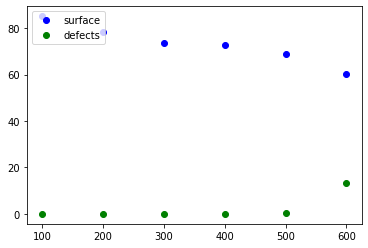

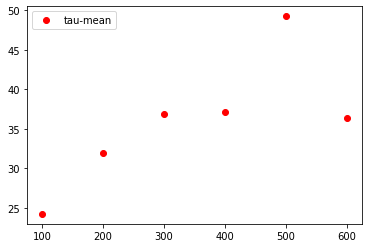

In [44]:
# vary temperature from 100 to 600 K ...
activation_energy_eV_per_K = 0.9 # eV/K // Cu

grain_radius = 300. # nm

T       = []
t       = []
surface = []
voids   = []

for i in range(1,7,1):
  fps, fv, tau_mean = determine_fraction_of_particles_reaching_the_surface_considering_void_like_defects(number_of_events=1000, 
                                           ambient_temperature_in_K=i*100., 
                                           decay_in_ps=110.,                           # Cu
                                           D_in_cm2_per_s=1.5,                         # Cu 
                                           mean_grain_radius_in_nm=grain_radius,              
                                           poisson_distributed_grains=False, 
                                           gaussian_distributed_grains=False, 
                                           stddev_grain_radius_in_nm=50.,              
                                           start_at_center=False,                      
                                           discretize_motion=False,                    
                                           use_constant_time=False,                    
                                           use_constant_velocity=True,                
                                           concentration_of_voids=calcDefectEqConcentration(temperature=i*100.,activation_energy_eV_per_K=activation_energy_eV_per_K),                
                                           void_radius_of_interaction_in_Angstrom=1.4, # Cu 
                                           number_of_atoms_per_unit_cell=4,            # Cu // bcc:2, fcc:4, hcp:6
                                           volume_of_unit_cell_in_Angstrom3=3.615**3,  # Cu
                                           verbose=0)
  
  T.append(i*100.)
  t.append(tau_mean)
  surface.append(fps)
  voids.append(fv)

  print('T={} K // surface={} % // defects={} % // tau-mean-bulk={} ps'.format(i*100.,fps,fv,tau_mean))

print('fraction vs. temperature')
plt.plot(T,surface,'bo',label='surface')
plt.plot(T,voids,'go',label='defects')
plt.legend(loc="upper left")
plt.show()

plt.plot(T,t,'ro',label='tau-mean')
plt.legend(loc="upper left")
plt.show()